<a href="https://colab.research.google.com/github/Lucasl3/Problemas-IA/blob/main/knn/Classificador_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import math 
import matplotlib.pyplot as plt
import seaborn as sns

# Lendo o dataset

In [ ]:
url = "https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv"
dataset = pd.read_csv(url)

# Traduzindo as colunas

In [ ]:
mapa = {
    "mileage_per_year": "milhas_por_ano",
    "model_year": "ano_do_modelo",
    "price": "preco",
    "sold": "vendido"
}
trocar_vendido = {
    "no": 0,
    "yes": 1
}

dataset.rename(columns = mapa, inplace = True)
dataset.vendido = dataset.vendido.map(trocar_vendido)
dataset.head()

,Unnamed: 0,milhas_por_ano,ano_do_modelo,preco,vendido
0,0,21801,2000,30941.02,1
1,1,7843,1998,40557.96,1
2,2,7109,2006,89627.50,0
3,3,26823,2015,95276.14,0
4,4,7935,2014,117384.68,1


# Fazendo a transformação dos dados

In [ ]:
ano_atual = datetime.today().year
dataset["idade_modelo"] = ano_atual - dataset.ano_do_modelo 
dataset["km_por_ano"] = dataset.milhas_por_ano * 1.60934
dataset.drop(columns = ['Unnamed: 0', "milhas_por_ano", "ano_do_modelo"], axis=1, inplace = True)
dataset.query("preco > 0", inplace=True)

dataset

,preco,vendido,idade_modelo,km_por_ano
0,30941.02,1,22,35085.22134
1,40557.96,1,24,12622.05362
2,89627.50,0,16,11440.79806
3,95276.14,0,7,43167.32682
4,117384.68,1,8,12770.11290
...,...,...,...,...
9995,97112.86,0,16,25060.64248
9996,107424.63,1,20,21317.31764
9997,93856.99,0,8,20950.38812
9998,51250.57,1,11,16840.13376


# KNN

In [ ]:
dataset_knn = dataset.copy(deep=True).sample(1500, random_state=220)
dataset_knn

,preco,vendido,idade_modelo,km_por_ano
398,48904.71,0,22,14855.81754
7655,48704.47,1,23,12519.05586
5738,61645.21,0,16,16836.91508
4154,84121.99,0,23,32611.66576
446,111244.38,0,17,17062.22268
...,...,...,...,...
5706,38869.12,1,21,15794.06276
4013,60547.19,0,19,25033.28370
6154,81819.66,0,23,33392.19566
297,60963.98,1,12,20902.10792


Normalizando os dados





In [ ]:
def normalize(dataset, columns):
  for column in columns:
    dataset[column] = (dataset[column] - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

  return dataset

dataset_knn = normalize(dataset_knn, ["preco", "idade_modelo", "km_por_ano"])
dataset_knn

,preco,vendido,idade_modelo,km_por_ano
398,0.397443,0,0.894737,0.187238
7655,0.395681,1,0.947368,0.145335
5738,0.509547,0,0.578947,0.222764
4154,0.707321,0,0.947368,0.505642
446,0.945971,0,0.631579,0.226804
...,...,...,...,...
5706,0.309139,1,0.842105,0.204063
4013,0.499885,0,0.736842,0.369744
6154,0.687062,0,0.947368,0.519639
297,0.503552,1,0.368421,0.295662


In [ ]:
SEED = 127
np.random.seed(SEED)

Dataset de treino

In [ ]:
train = dataset_knn.sample(frac=0.7,random_state=SEED)
train_x, train_y = train[["preco", "idade_modelo", "km_por_ano"]], train[["vendido"]]
train_x.reset_index(inplace=True)
train_y.reset_index(inplace=True)

Dataset de teste

In [ ]:
test = dataset_knn.drop(train.index)
test_x, test_y = test[["preco", "idade_modelo", "km_por_ano"]], test["vendido"]
test_x

,preco,idade_modelo,km_por_ano
5738,0.509547,0.578947,0.222764
5734,0.771311,0.052632,0.461689
8057,0.692583,0.789474,0.370148
1672,0.552629,0.789474,0.268073
9682,0.761072,0.789474,0.400335
...,...,...,...
5988,0.481474,0.210526,0.252778
7995,0.339397,0.157895,0.269949
6154,0.687062,0.947368,0.519639
297,0.503552,0.368421,0.295662


In [ ]:
def func(e):
  return e["distancia"]

def euclidean_distance(teste, treino):
  somatorio = 0
  for i in range(0, len(teste)):
    somatorio += (treino[i] - teste[i]) ** 2

  return math.sqrt(somatorio)


def knn_algorithm(teste, train_x, n):
  distancias = []
  
  for index, linha in train_x.iterrows():
    preco, idade_modelo, km_por_ano = linha["preco"], linha["idade_modelo"], linha["km_por_ano"]
    distancia = euclidean_distance(teste, (preco, idade_modelo, km_por_ano))
    distancias.append({
        "index": index,
        "distancia": distancia
    }) 

  distancias.sort(key=func)
  return distancias[:n]

def sera_vendido(knn):
  vendido = 0
  for i in knn:
    index = i["index"]
    
    if train_y.iloc[index]["vendido"] == 1:
      vendido += 1
    else:
      vendido += -1
  
  return 1 if vendido > 0 else 0


def main():
  testes = {
      "preco": [],
      "idade_modelo": [],
      "km_por_ano": [],
      "vendido": []
  }

  k = 5
  for index, linha in test_x.iterrows():
    preco, idade_modelo, km_por_ano = linha["preco"], linha["idade_modelo"], linha["km_por_ano"]
    knn = knn_algorithm((preco, idade_modelo, km_por_ano), train_x, k)

    vendido = sera_vendido(knn)

    testes["preco"].append(preco)
    testes["idade_modelo"].append(idade_modelo)
    testes["km_por_ano"].append(km_por_ano)
    testes["vendido"].append(vendido)
  
  df_previsao = pd.DataFrame(testes)
  print(df_previsao)
  return df_previsao
  

if __name__ == "__main__":
    df_previsao = main()

        preco  idade_modelo  km_por_ano  vendido
0    0.509547      0.578947    0.222764        1
1    0.771311      0.052632    0.461689        0
2    0.692583      0.789474    0.370148        0
3    0.552629      0.789474    0.268073        1
4    0.761072      0.789474    0.400335        0
..        ...           ...         ...      ...
445  0.481474      0.210526    0.252778        1
446  0.339397      0.157895    0.269949        1
447  0.687062      0.947368    0.519639        0
448  0.503552      0.368421    0.295662        0
449  0.381697      0.684211    0.270295        1

[450 rows x 4 columns]


In [ ]:
previsoes = df_previsao["vendido"]
print(previsoes)
print((test_y))

0      1
1      0
2      0
3      1
4      0
      ..
445    1
446    1
447    0
448    0
449    1
Name: vendido, Length: 450, dtype: int64
5738    0
5734    0
8057    0
1672    1
9682    0
       ..
5988    1
7995    1
6154    0
297     1
2507    1
Name: vendido, Length: 450, dtype: int64


In [ ]:
def get_matriz_confusao(teste_y, previsoes):
  matriz = np.zeros((2, 2))
  for index, vendido in enumerate(teste_y):
    if vendido:
      if previsoes.loc[index]:
        matriz[0][0] += 1
      else:
        matriz[1][0] += 1
    else:
      if not previsoes.loc[index]:
        matriz[1][1] += 1
      else:
        matriz[0][1] += 1
  
  return matriz

matriz_confusao = get_matriz_confusao(test_y, previsoes)
matriz_confusao

array([[198.,  56.],
       [ 52., 144.]])

## Métricas

In [ ]:
def accuracy_score(matriz):
  tamanho = matriz.sum()
  acertos = matriz.diagonal().sum()
  
  return acertos/tamanho

accuracy = round(accuracy_score(matriz_confusao) * 100, 2)
print(f"A acurácia foi de {round(accuracy, 2)}%")
print(f"A taxa de erro foi de {round(100 - accuracy, 2)}%")

A acurácia foi de 76.0%
A taxa de erro foi de 24.0%


In [ ]:
VP = matriz_confusao[0][0]
FP = matriz_confusao[0][1]
FN = matriz_confusao[1][0]
VN = matriz_confusao[1][1]

precisao_vendido = round((VP / (VP + FP)) * 100, 2)
precisao_nao_vendido = round((VN / (FN + VN)) * 100, 2)
cobertura_vendido = round((VP / (VP + FN)) * 100, 2)
cobertura_nao_vendido = round((VN / (VN + FP)) * 100, 2)

print(f"""Precisão-vendido: {precisao_vendido}%
Precisão-não-vendido: {precisao_nao_vendido}%
Cobertura-vendido: {cobertura_vendido}%
Cobertura-não-vendido: {cobertura_nao_vendido}%""")

Precisão-vendido: 77.95%
Precisão-não-vendido: 73.47%
Cobertura-vendido: 79.2%
Cobertura-não-vendido: 72.0%


## Matriz de Confusão

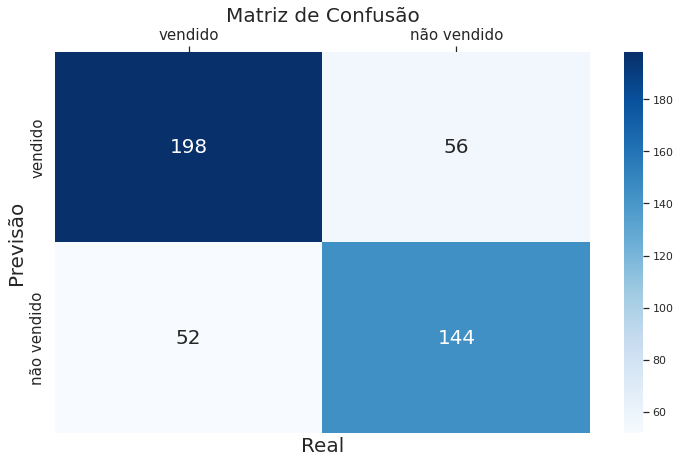

In [ ]:
sns.set(rc={'figure.figsize':(12, 7)})

ax = sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='.0f', annot_kws={"size": 20})

ax.set_title("Matriz de Confusão", fontsize=20)
ax.set_xlabel("Real", fontsize=20)
ax.set_ylabel("Previsão", fontsize=20)

ax.set_xticklabels(["vendido", "não vendido"], fontsize=15)
ax.set_yticklabels(["vendido", "não vendido"], fontsize=15)
ax.xaxis.tick_top()


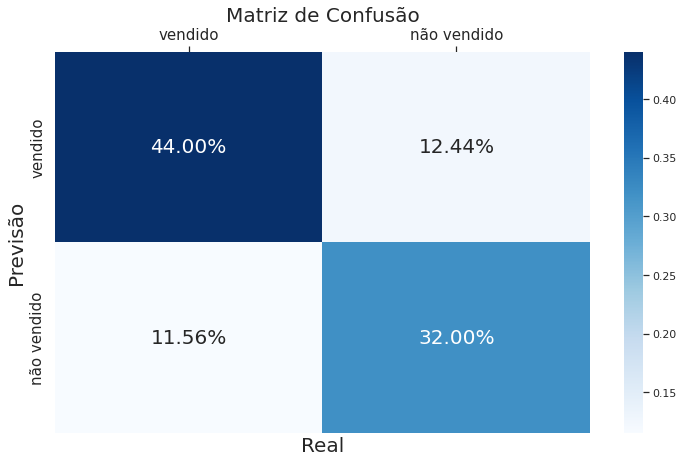

In [ ]:
ax = sns.heatmap(matriz_confusao/np.sum(matriz_confusao), annot=True, cmap='Blues', fmt=".2%", annot_kws={"size": 20})

ax.set_title("Matriz de Confusão", fontsize=20)
ax.set_xlabel("Real", fontsize=20)
ax.set_ylabel("Previsão", fontsize=20)

ax.set_xticklabels(["vendido", "não vendido"], fontsize=15)
ax.set_yticklabels(["vendido", "não vendido"], fontsize=15)
ax.xaxis.tick_top()

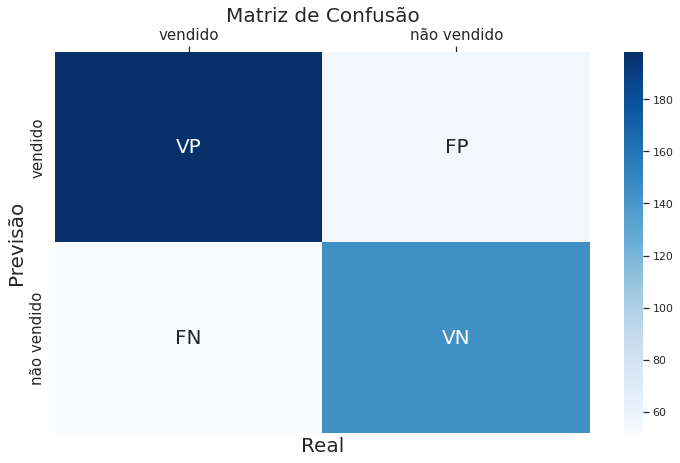

In [ ]:
# labels = ["True Pos", "False Pos", "False Neg", "True Neg"]
labels = ["VP", "FP", "FN", "VN"]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(matriz_confusao, annot=labels, cmap='Blues', fmt="", annot_kws={"size": 20})

ax.set_title("Matriz de Confusão", fontsize=20)
ax.set_xlabel("Real", fontsize=20)
ax.set_ylabel("Previsão", fontsize=20)

ax.set_xticklabels(["vendido", "não vendido"], fontsize=15)
ax.set_yticklabels(["vendido", "não vendido"], fontsize=15)
ax.xaxis.tick_top()